
## Imports

In [1]:
import numpy as np
import pandas as pd
import csv
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import StratifiedKFold

## Loading Data

In [3]:
df = pd.read_csv("tokenized_eng.csv",
                 na_values=['[deleted]', '[removed]']).dropna()

### Preparing data (Sampling)

#### Undersampling majority class (Western class)

In [4]:
from sklearn.utils import resample

# Undersample the majority class
df_western = df[df['Poles'] == 'Western']
df_eastern = df[df['Poles'] == 'Eastern']

df_western_downsampled = resample(df_western, replace=False, n_samples=len(df_eastern), random_state=42)

df_balanced = pd.concat([df_western_downsampled, df_eastern])
df_balanced

,Unnamed: 0,auhtor_ID,post,nationality,Poles,tokens,eng_tokens,average_word_length,avg_sentence_length
39852,42536,t2_3jee3cx4,everything cannot generalized co2 cost envirom...,Denmark,Western,"['everything', 'can', 'not', 'generalized', 'c...","[""'everything'"", ""'can'"", ""'not'"", ""'generaliz...",5.748591,51.508772
57664,62136,t2_dj2ua,"trump's favour, would posting this? #facts als...",Germany,Western,"['trump', ""'s"", 'favour', ',', 'would', 'posti...","[""'trump'"", ""'s'"", ""'would'"", ""'posting'"", ""'t...",6.072072,46.782609
6463,6797,t2_59w0o,thought like comparing south american club eur...,The Netherlands,Western,"['thought', 'like', 'comparing', 'south', 'ame...","[""'thought'"", ""'like'"", ""'south'"", ""'club'"", ""...",5.539877,47.454545
73232,79369,t2_f8l2p,"jag är inte längre krigsplacerad, men jag kan ...",Sweden,Western,"['jag', 'är', 'inte', 'längre', 'krigsplacerad...","[""'jag'"", ""'men'"", ""'jag'"", ""'kan'"", ""'och'"", ...",5.166295,94.471264
6254,6569,t2_32nmh,"borders, maritime base constrained position co...",The Netherlands,Western,"['borders', ',', 'maritime', 'base', 'constrai...","[""'maritime'"", ""'base'"", ""'constrained'"", ""'po...",5.767805,69.080808
...,...,...,...,...,...,...,...,...,...
75855,82066,t2_8hacr7if,raid vitro facilities. good hunt! mean governm...,Poland,Eastern,"['raid', 'vitro', 'facilities', '.', 'good', '...","[""'raid'"", ""'good'"", ""'hunt'"", ""'mean'"", ""'gov...",5.697468,49.875000
75856,82067,t2_8hacr7if,homemade one kill people already multiple poli...,Poland,Eastern,"['homemade', 'one', 'kill', 'people', 'already...","[""'homemade'"", ""'one'"", ""'kill'"", ""'people'"", ...",5.790725,50.450450
75857,82068,t2_8hacr7if,head. look like imperialism back menu boys! go...,Poland,Eastern,"['head', '.', 'look', 'like', 'imperialism', '...","[""'head'"", ""'look'"", ""'like'"", ""'imperialism'""...",5.671835,47.716981
75858,82069,t2_8hacr7if,purgatory. wil help soul get heaven quicker kn...,Poland,Eastern,"['purgatory', '.', 'wil', 'help', 'soul', 'get...","[""'purgatory'"", ""'help'"", ""'soul'"", ""'get'"", ""...",5.748459,47.866071


In [7]:
df_balanced = df_balanced[df_balanced['nationality'] != "USA"]

### Converting to FastText Format

In [8]:
# Creating a copy as data
data = df_balanced.copy()

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Add the __label__ prefix to each label
train_data['category'] = train_data['Poles'].apply(lambda x: f'__label__{x}')
test_data['category'] = test_data['Poles'].apply(lambda x: f'__label__{x}')

# Saving the CSV file as a text file to train/test the classifier
train_data[['category', 'post']].to_csv('train.txt',
                                          index = False,
                                          sep = ' ',
                                          header = None,
                                          quoting = csv.QUOTE_NONE,
                                          quotechar = "",
                                          escapechar = " ")

test_data[['category', 'post']].to_csv('test.txt',
                                     index = False,
                                     sep = ' ',
                                     header = None,
                                     quoting = csv.QUOTE_NONE,
                                     quotechar = "",
                                     escapechar = " ")

In [9]:
# Creating a copy as data
data = df_balanced.copy()

# Add the __label__ prefix to each label
data['category'] = data['Poles'].apply(lambda x: f'__label__{x}')

# Saving the CSV file as a text file to train/test the classifier
data[['category', 'post']].to_csv('data.txt',
                                          index = False,
                                          sep = ' ',
                                          header = None,
                                          quoting = csv.QUOTE_NONE,
                                          quotechar = "",
                                          escapechar = " ")

### Train and Test

In [10]:
# Training the fastText classifier
model = fasttext.train_supervised('train.txt', wordNgrams=2, epoch=10, lr=0.1)

# Evaluating performance on the entire test file
model.test('test.txt', k=1)

(8705, 0.9089029293509477, 0.9089029293509477)

* 8705 is the number of data points in the test set
* 0.90890 is both the precision and the recall

In [11]:
# Evaluate on training data
train_result = model.test("train.txt")
train_result

(20311, 0.941066417212348, 0.941066417212348)

### K-fold CV (check for overfitting)

In [12]:
# Replace with your actual data and parameters
data_path = 'data.txt'
k_folds = 10  # Choose the number of folds

# Load your data into a list
with open(data_path, 'r', encoding='utf-8') as file:
    data_lines = file.readlines()

# Extract labels and texts
labels = [line.split()[0] for line in data_lines]
texts = [' '.join(line.split()[1:]) for line in data_lines]

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store precision scores for each fold
precision_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(texts, labels):
    # Split the data into training and testing sets
    train_data = [texts[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    test_data = [texts[i] for i in test_index]
    test_labels = [labels[i] for i in test_index]

    # Create FastText training and testing files
    with open('train_fold.txt', 'w', encoding='utf-8') as train_file:
        for label, text in zip(train_labels, train_data):
            train_file.write(f'__label__{label} {text}\n')

    with open('test_fold.txt', 'w', encoding='utf-8') as test_file:
        for label, text in zip(test_labels, test_data):
            test_file.write(f'__label__{label} {text}\n')

    # Train the FastText model
    model = fasttext.train_supervised(input='train_fold.txt', wordNgrams=2, epoch=10, lr=0.1)

    # Evaluate on the test set
    result = model.test('test_fold.txt')[1]
    precision_scores.append(result)

# Print precision scores for each fold
for i, precision in enumerate(precision_scores, start=1):
    print(f'Fold {i}: Precision = {precision:.4f}')

# Calculate and print the average precision across all folds
average_precision = np.mean(precision_scores)
print(f'Average Precision: {average_precision:.4f}')

Fold 1: Precision = 0.9245
Fold 2: Precision = 0.9225
Fold 3: Precision = 0.9180
Fold 4: Precision = 0.9290
Fold 5: Precision = 0.9187
Fold 6: Precision = 0.9221
Fold 7: Precision = 0.9152
Fold 8: Precision = 0.9173
Fold 9: Precision = 0.9238
Fold 10: Precision = 0.9214
Average Precision: 0.9213


Perform k-fold cross-validation, where the dataset is divided into k subsets, and the model is trained and tested k times, each time using a different subset as the test set. If the model consistently performs well across different subsets, it is less likely to be overfitting.

#### Meaning of k parameter

(Taken from Chat)
Now, when you set k=1, it means you are only considering the top-1 prediction for each example. In your case, the precision and recall at 1 are both approximately 0.9465.

When you set k=2, it means you are considering the top-2 predictions for each example. This changes the evaluation metric because now the model is allowed to provide two predictions per example, and correctness is assessed based on whether the correct category is among the top-2 predictions.

So it does not make sense to set k to anything above 1 in case of binary predictions since there are only two categories.

### More Evaluation metrics

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load the test data
with open('test.txt', 'r', encoding='utf-8') as f:
    test_lines = f.readlines()

# Extract labels and texts from the test data
test_labels = [line.split()[0] for line in test_lines]
test_texts = [' '.join(line.split()[1:]) for line in test_lines]

# Get predictions from the model
predictions = [model.predict(text)[0][0].replace('__label__', '') for text in test_texts]

# Create label mapping to map strings as integers (0 or 1)
label_mapping = {'__label__Western': 0, '__label__Eastern': 1}
label_mapping_pred = {'Western': 0, 'Eastern': 1}

# Convert labels to integers using the mapping
test_labels = [label_mapping[label] for label in test_labels]
predictions = [label_mapping_pred[pred] for pred in predictions]

# Calculate and print evaluation metrics
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')
classification_rep = classification_report(test_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.9515221137277426
Precision: 0.9515293270234577
Recall: 0.9515221137277426
F1 Score: 0.9515249139872042
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4076
           1       0.96      0.95      0.95      4629

    accuracy                           0.95      8705
   macro avg       0.95      0.95      0.95      8705
weighted avg       0.95      0.95      0.95      8705



#### Getting top Western and Eastern words (important words)

In [14]:
punctuation_matches = df_balanced.post.str.findall(
    '[^\w\s]')  # matches any character that is not a word character(\w) or a whitespace character(\s).

tokens = df_balanced.post.str.findall(
    '\w+|[^\w\s]')  # match either a sequence of word characters or any non-word, non-space character.

df_balanced['token'] = tokens

tokens.head(5)

39852    [everything, cannot, generalized, co2, cost, e...
57664    [trump, ', s, favour, ,, would, posting, this,...
6463     [thought, like, comparing, south, american, cl...
73232    [jag, är, inte, längre, krigsplacerad, ,, men,...
6254     [borders, ,, maritime, base, constrained, posi...
Name: post, dtype: object

In [16]:
# Making a western (T/F) column
western = ["Finland", "Germany", "Greece", "The Netherlands", "Ireland", "Spain", "United Kingdom", "Denmark", "France", "Italy", "Sweden", "Switzerland", "Norway", "Belgium", "Austria", "Portugal", "Luxembourg", "Iceland", "Greenland", "Malta"]

df_balanced.loc[:, "Western"] = df_balanced["nationality"].apply(lambda x: x in western)

In [17]:
def top_words_west_east(token_df, western=True):
    counter = Counter()
    for ix, row in token_df.iterrows():
        if western and row['Western']:
            counter += Counter(row['token'])
        elif not western and not row['Western']:
            counter += Counter(row['token'])

    top_words = set([w for w, i in counter.most_common(5000)])
    return top_words

In [18]:
# Assuming 'Western' column is boolean (True/False)
top_western_words = list(top_words_west_east(df_balanced, western=True))

top_western_words

['lieber',
 'understandable',
 'shown',
 'americans',
 'commit',
 'beating',
 'decent',
 'uit',
 'mask',
 'direkt',
 'update',
 'me',
 'external',
 'words',
 'finance',
 'monitor',
 'using',
 'discus',
 'honestly',
 'whereas',
 'meme',
 'desktop',
 'um',
 'achieve',
 'egal',
 'ofc',
 'racial',
 'individual',
 'view',
 'shirt',
 'structure',
 'τα',
 'filled',
 'totally',
 'sont',
 'consider',
 'him',
 'romance',
 'aim',
 'hurt',
 'invest',
 'sans',
 'cleaning',
 'busy',
 'joe',
 '…',
 'respond',
 'report',
 'wahrscheinlich',
 'defensive',
 'program',
 'proven',
 'controller',
 'etc',
 'april',
 'culture',
 'trade',
 'procedure',
 'burger',
 'danger',
 'autres',
 'always',
 'chosen',
 'chocolate',
 'sentiment',
 'posts',
 'air',
 'ideology',
 'chad',
 'company',
 'afaik',
 'collect',
 'used',
 'say',
 'bunch',
 'goed',
 'pad',
 'communism',
 'apple',
 '͝',
 'racism',
 'mediterranean',
 'nel',
 'match',
 'x',
 'bzw',
 'picking',
 'kuin',
 'sound',
 'tra',
 '—',
 'dell',
 'crime',
 'li',
 

In [19]:
top_eastern_words = list(top_words_west_east(df_balanced, western=False))

top_eastern_words

['understandable',
 'shown',
 'americans',
 'prvi',
 'commit',
 'beating',
 'kde',
 'decent',
 'mask',
 'update',
 'me',
 'external',
 'words',
 'monitor',
 'using',
 'georgia',
 'discus',
 'honestly',
 'zi',
 'whereas',
 'ih',
 'meme',
 'achieve',
 'ofc',
 'nam',
 'individual',
 'view',
 'shirt',
 'structure',
 'τα',
 'filled',
 'totally',
 'netko',
 'svaki',
 'mogao',
 'consider',
 'him',
 'aim',
 'hurt',
 'probabil',
 'invest',
 'zelo',
 'busy',
 'joe',
 '…',
 'respond',
 'february',
 'report',
 'defensive',
 'program',
 'proven',
 '6th',
 'controller',
 'rn',
 'etc',
 'april',
 'culture',
 'trade',
 'danger',
 'always',
 'chosen',
 'chocolate',
 'zici',
 'sentiment',
 'posts',
 'air',
 'ideology',
 'chad',
 'company',
 'bude',
 'afaik',
 'collect',
 'used',
 'say',
 'bunch',
 'nje',
 'soldiers',
 'prince',
 'communism',
 'apple',
 '͝',
 'racism',
 'match',
 'x',
 'picking',
 'sound',
 '—',
 'crime',
 'li',
 'attack',
 'mistake',
 'volna',
 'prost',
 '-',
 'ear',
 'full',
 'haha',
 

#### Two-dimensional representation of word embeddings (vector space)

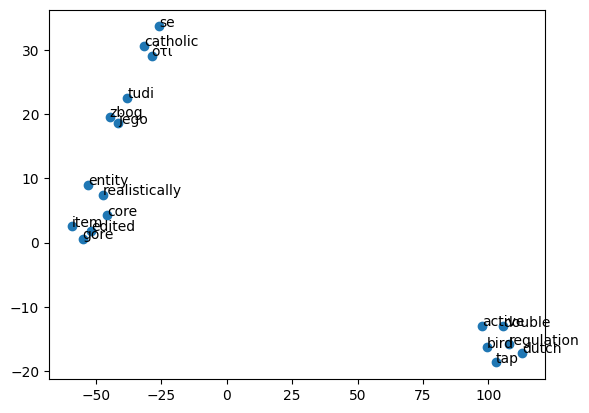

In [64]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

words = ['local', 'equipment', 'deaths', 'cannot', 'normally', 'smoke', 'engage', 'Hitler', 'add', 'London',
         'London', 'land', 'matter', 'on', 'Egypt']

vectors = [model.get_word_vector(word) for word in top_eastern_words[0:18]]

# Convert list of lists to a 2D NumPy array
vectors = np.array(vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
# perplexity is a hyperparameter that influences the balance between preserving
# local and global structures in the data.
# perplexity needs to be lower than the number of words in the vector space
vectors_tsne = tsne.fit_transform(vectors)

plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(top_eastern_words[0:18]):
    plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]))

plt.show()

perplexity is a hyperparameter that influences the balance between preserving local and global structures in the data.

importance of single words in a bigram model:
*  Indicates how frequent bigrams containing said word are in the training data
* position (index) of a bigram in the vocabulary is a reflection of its frequency in the training data

Importance score in FastText is misleading. It refers to the frequency of the word in the training data.

* Low importance score indicates high frequency (these words are often not important for classification as they have less discriminatory power in distinguishing between classes since it is present in both classes)
* High importance score indicates low frequency (these words are more importance for classification task; carry more discriminatory power)

Note: if the score is -1, the word does not exist in the training data


# FastText as input for another model

### Creating Feature Matrix (word weights)

In [14]:
import pandas as pd
import numpy as np

# Initialize empty lists to store data
author_ids = []
feature_vectors = []
labels = []

# Iterate through each row in the DataFrame
for index, row in df_balanced.iterrows():
    text = row['post']

    # Get the sentence vector using get_sentence_vector
    sentence_vector = model.get_sentence_vector(text)

    # Append author_id, feature_vector, and label to respective lists
    author_ids.append(row['auhtor_ID'])
    feature_vectors.append(sentence_vector)
    labels.append(row['Poles'])

# Create a new DataFrame with author IDs, feature vectors, and labels
columns = [f'feature_{i}' for i in range(len(feature_vectors[0]))]
data = np.concatenate([np.array(author_ids).reshape(-1, 1), np.array(feature_vectors), np.array(labels).reshape(-1, 1)], axis=1)
new_df = pd.DataFrame(data, columns=['auhtor_ID'] + columns + ['Poles'])

# Convert feature columns to numeric
new_df[columns] = new_df[columns].apply(pd.to_numeric)

# Print the new DataFrame
new_df

,auhtor_ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,Poles
0,t2_3jee3cx4,0.011011,-0.002747,0.015690,0.008727,-0.000296,-0.005595,-0.018028,0.024939,-0.021262,...,0.006383,-0.015139,-0.003372,0.002170,-0.007359,-0.009538,-0.012377,-0.010063,0.011452,Western
1,t2_dj2ua,0.005330,-0.001484,0.007758,0.004165,-0.000357,-0.002562,-0.008691,0.011706,-0.009852,...,0.002641,-0.006967,-0.001868,0.001075,-0.003738,-0.004547,-0.005662,-0.004946,0.005202,Western
2,t2_59w0o,0.004827,-0.001591,0.007050,0.004104,-0.000178,-0.002312,-0.008173,0.011268,-0.009666,...,0.002903,-0.006776,-0.001964,0.001206,-0.003621,-0.004633,-0.005204,-0.004655,0.004667,Western
3,t2_f8l2p,0.025177,-0.005956,0.037338,0.019853,-0.000995,-0.013046,-0.042099,0.058451,-0.049871,...,0.014860,-0.035400,-0.008524,0.005335,-0.016604,-0.022509,-0.029510,-0.023134,0.026549,Western
4,t2_32nmh,0.018291,-0.004315,0.026543,0.014478,-0.000676,-0.009265,-0.030065,0.041583,-0.035364,...,0.010754,-0.025154,-0.006154,0.004051,-0.011993,-0.016176,-0.020571,-0.016450,0.019162,Western
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29011,t2_8hacr7if,-0.004568,0.000968,-0.006716,-0.003953,-0.000024,0.002377,0.007697,-0.010437,0.009200,...,-0.003080,0.006751,0.001064,-0.001255,0.002747,0.004117,0.005392,0.004033,-0.004791,Eastern
29012,t2_8hacr7if,-0.006955,0.001726,-0.010367,-0.005701,0.000526,0.003699,0.010965,-0.016032,0.013791,...,-0.004182,0.009999,0.002407,-0.001634,0.004426,0.005775,0.008244,0.006236,-0.007125,Eastern
29013,t2_8hacr7if,-0.005220,0.001155,-0.008380,-0.004182,0.000242,0.002699,0.008523,-0.012174,0.010669,...,-0.003030,0.007762,0.001585,-0.001246,0.003650,0.004700,0.005912,0.004725,-0.005604,Eastern
29014,t2_8hacr7if,-0.002832,0.000700,-0.004338,-0.002514,0.000391,0.001236,0.004514,-0.006759,0.005653,...,-0.001664,0.004436,0.000932,-0.000782,0.001886,0.002768,0.003428,0.002658,-0.003025,Eastern


### Simple Logistic Regression (baseline)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming new_df is your DataFrame with features and labels
X = new_df.drop(['auhtor_ID', 'Poles'], axis=1)
y = new_df['Poles']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
clf = LogisticRegression(penalty='l2', C=1.0)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Generate a classification report
class_report = classification_report(y_test, predictions)
print('Classification Report:\n', class_report)

Accuracy: 0.9502342866375828
Precision: 0.9509127298018376
Recall: 0.9502342866375828
F1-score: 0.9502033470116344
Classification Report:
               precision    recall  f1-score   support

     Eastern       0.97      0.93      0.95      3058
     Western       0.93      0.97      0.95      3131

    accuracy                           0.95      6189
   macro avg       0.95      0.95      0.95      6189
weighted avg       0.95      0.95      0.95      6189



### Testing for Overfitting

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=10, scoring='f1_weighted')

# Print cross-validation scores
print('Cross-Validation Scores:', cv_scores)
print('Mean CV Accuracy:', np.mean(cv_scores))

Cross-Validation Scores: [0.95573492 0.96381117 0.95538932 0.93499937 0.96024513 0.9327056
 0.95701282 0.96574014 0.92551866 0.93627565]
Mean CV Accuracy: 0.9487432776453719


#### Feature importance

In [73]:
# Check if the model has the attribute coef_ (handles regularization)
if hasattr(clf, 'coef_'):
    coefficients = clf.coef_[0]
else:
    # For models with regularization, coefficients are stored in coef_ only if not regularized
    coefficients = clf.coef_

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort features by absolute coefficient values (importance)
feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the feature importance DataFrame
feature_importance_df

,Feature,Coefficient,Absolute_Coefficient
44,feature_44,12.560395,12.560395
5,feature_5,12.520909,12.520909
11,feature_11,11.839151,11.839151
12,feature_12,-11.415024,11.415024
15,feature_15,-10.820159,10.820159
...,...,...,...
81,feature_81,0.273564,0.273564
9,feature_9,0.201929,0.201929
25,feature_25,-0.196861,0.196861
22,feature_22,-0.166847,0.166847


It is impossible to interpret the meanings of these features since they are weights from the FastText model's word vector representations. Since the model learns these weights during training, and since these weights encode some sort of semantic meaning it becomes impossible to understand what these weights actually are semantically

### Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the neural network model
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9520116335433835


#### Testing for overfitting

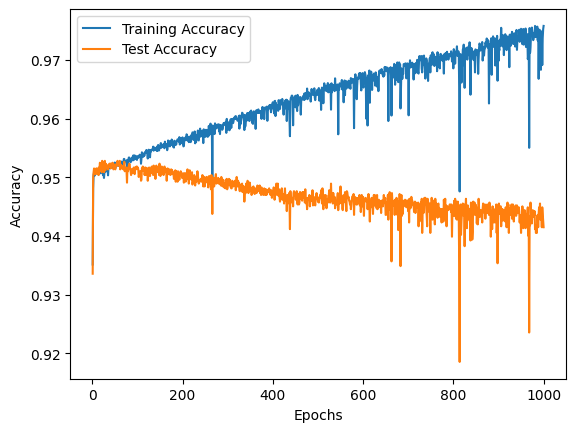

In [78]:
## - Accuracy graphs for training and testing - ##

import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize neural network model
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True)

# Lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Number of training iterations (epochs)
n_epochs = 1000

# Train the model in multiple epochs
for epoch in range(n_epochs):
    # Train the model with a small batch of data
    clf.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

    # Evaluate the model on the training set
    train_predictions = clf.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the test set
    test_predictions = clf.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_accuracies.append(test_accuracy)

# Plot training and test accuracies
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

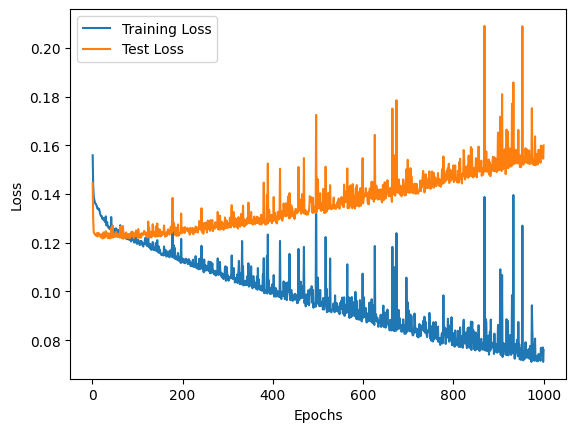

In [80]:
## - Loss graphs for training and testing - ##

import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# Standardize features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize neural network model
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Number of training iterations (epochs)
n_epochs = 1000

# Train the model in multiple epochs
for epoch in range(n_epochs):
    # Train the model with a small batch of data
    clf.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

    # Compute the loss on the training set
    train_predictions_proba = clf.predict_proba(X_train_scaled)
    train_loss = log_loss(y_train, train_predictions_proba)
    train_losses.append(train_loss)

    # Compute the loss on the test set
    test_predictions_proba = clf.predict_proba(X_test_scaled)
    test_loss = log_loss(y_test, test_predictions_proba)
    test_losses.append(test_loss)

# Plot training and test losses
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

So the model is definitely overfitting since the training accuracy continues to increase while the test accuracy decreases over the number of epochs. So this certainly needs to be taken care of.